# Regression sTDA

-NOTE: 
- PubChemQC DFT calculations were run on GAUSSIAN with wb97X-D
- Hexamer DFT calculations were run on ORCA with wb97X (no dispersion)

### Imports

In [1]:
import pandas as pd
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

### Data Processing

Combine PubChemQC & Wide Range DFs

In [17]:
# NOTE: dft_alpha column uses slightly different methods for pcqc & hexamers; see note at top
master = pd.read_csv('master_polarizability.csv')
master

,Unnamed: 0,name,stda_alpha(bohr),stda_alpha(A^3),gfn2_alpha(A^3),dft_alpha(A^3)
0,0,44024074,103.697395,15.366398,27.064021,29.764381
1,1,42077092,45.854966,6.795018,24.463479,24.706837
2,2,23522360,3.093276,0.458377,20.490624,19.972335
3,3,23512851,26.545382,3.933627,17.860015,17.140526
4,4,23517543,27.901622,4.134602,17.257429,17.140526
...,...,...,...,...,...,...
8483,8483,3E5E-octa-1357-tetraene,101.372833,15.021933,14.152759,19.107494
8484,8484,benzo-a-anthracene,163.332638,24.203447,27.828351,33.077176
8485,8485,pyrene,131.830131,19.535248,24.476532,27.143263
8486,8486,benzo-e-pyrene,154.798773,22.938856,30.398737,33.191500


### Method Definition

In [10]:
'''
    Calculates root mean square error

    Parameters
    ---------
    predictions: ndarray of floats
        expected values [based on best fit line]
    observations: ndarray of floats
        observed values
    
    Returns
    -------
    rmse: float
        root mean square error
'''
def calc_rmse(predictions, observations):
    rmse = np.sqrt(((predictions - observations) ** 2).mean())
    return rmse

In [11]:
'''
    Performs linear regression on data set and calculates associated values

    Parameters
    ---------
    x: ndarray of floats
        x values
    y: ndarray of floats
        y values
    intercept: boolean
        if true, calculates y intercept, if false sets y intercept to 0 (forces fit)
    
    Returns
    -------
    lin_regress_var: list of floats
        slope, y-intercept, r^2, root mean square error
'''

def perform_lin_regress(x, y, intercept=True):  
     
    # 2D X array necessary for sklearn
    xi = x.reshape((-1,1))

    model = LinearRegression(fit_intercept = intercept)
    model.fit(xi,y)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(xi,y)
    
    # calculate RMSE
    y_pred = y
    y_true = []
    for val in x: 
        y_tr = slope*val + intercept
        y_true.append(y_tr)
    y_true = np.array(y_true)

    rmse = calc_rmse(y_pred, y_true)
    
    lin_regress_var = [slope, intercept, r_squared, rmse]
    
    return lin_regress_var

In [12]:
# matplotlib global formatting

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.rcParams['figure.dpi'] = 300

# DFT vs sTDA

### Calculate MAE for Linear and Quadratic Fits

In [14]:
x = master['stda_alpha(A^3)'].values
y = master['dft_alpha(A^3)'].values

# perform linear regression
slope, intercept, r_squared, rmserror = perform_lin_regress(x, y, False)

master_copy = master.copy()
master_copy['linear'] = master_copy['stda_alpha(A^3)']*slope
master_copy.tail()

,name,stda_alpha(bohr),stda_alpha(A^3),gfn2_alpha(A^3),dft_alpha(A^3),linear
8483,3E5E-octa-1357-tetraene,101.372833,15.021933,14.152759,19.107494,14.939907
8484,benzo-a-anthracene,163.332638,24.203447,27.828351,33.077176,24.071285
8485,pyrene,131.830131,19.535248,24.476532,27.143263,19.428577
8486,benzo-e-pyrene,154.798773,22.938856,30.398737,33.191500,22.813600
8487,dibenzo-bi-phenazine,246.045763,36.460291,32.370326,44.656400,36.261202


In [15]:
# MAE wb97X(D) vs linear-fit sTDA
mae_l_stda=mean_absolute_error(master_copy['dft_alpha(A^3)'], master_copy['linear'])
mae_l_stda

15.85280032015207

### Calculate MAE for Huber regression

Note: Fitting with Huber regressor was tried, however it resulted in a linear fit line above most of the hexamer data likely due to the relatively large amount of PubChemQC data points compared to wide range set data points.  Therefore, we will choose to use regular linear fitting.

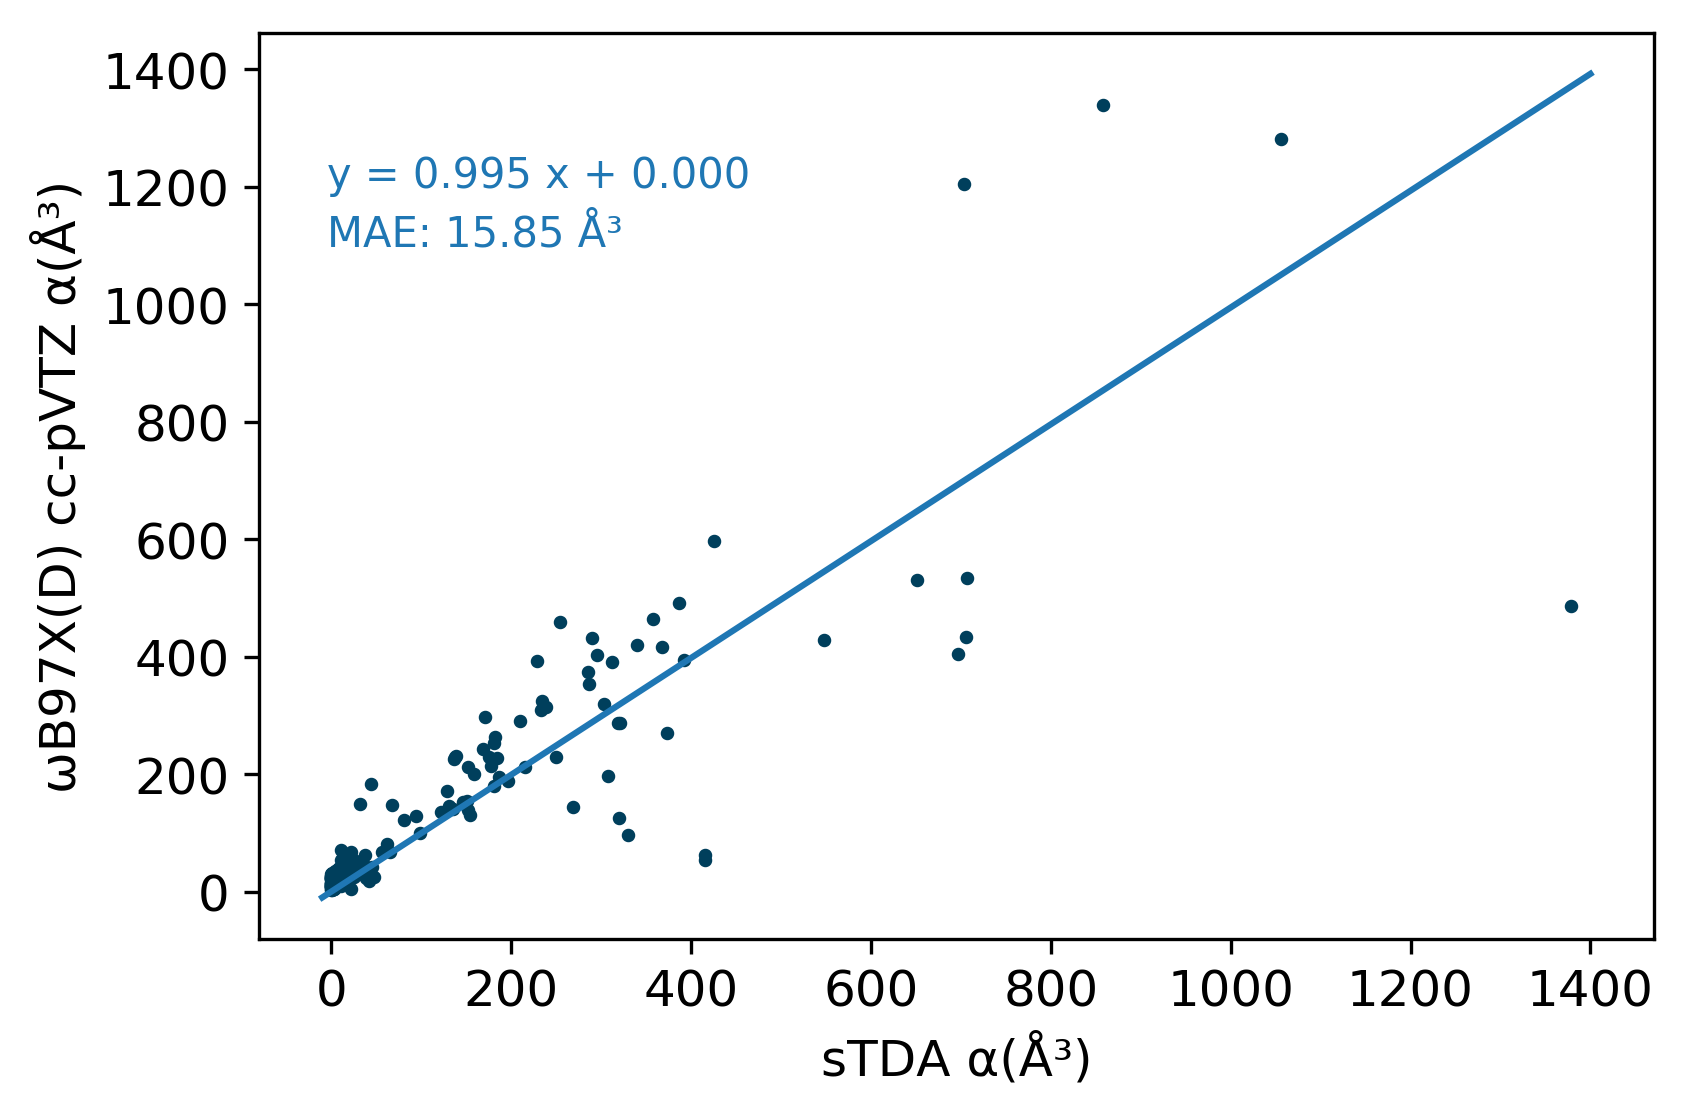

In [16]:
x = master['stda_alpha(A^3)'].values
y = master['dft_alpha(A^3)'].values

# label axes
plt.xlabel('sTDA α(Å³)')
plt.ylabel('ωB97X(D) cc-pVTZ α(Å³)')

# set axes limits
# plt.xlim(-20, 2000)

# perform linear regression
slope, intercept, r_squared, rmserror = perform_lin_regress(x, y, False)

# plot points & regression lines
plt.scatter(x, y, s=5, c='#003f5c')
# reassign x to grid of points (otherwise quadratic line will be warped)
x = np.linspace(-10, 1400, 10000)
plt.plot(x, slope*x+intercept, c='#1f77b4')

# print regression line equations
plt.text(-5, 1200, 'y = %.3f x + %.3f' % (slope, intercept), color='#1f77b4')
plt.text(-5, 1100, 'MAE: %.2f Å³' % mae_l_stda, color='#1f77b4')


# plt.savefig('stda_regression.png', transparent=False, bbox_inches='tight')

plt.show()